In [2]:
import numpy as np
import matplotlib.pyplot as plt
from jax.nn import relu
import jax.numpy as jnp
from jax import random, jit, jacobian, value_and_grad, vmap, jvp
from jax.flatten_util import ravel_pytree
from helper_functions import *
import optax
from scipy.linalg import block_diag

In [3]:
def random_params(di, Nh, do, key):
    w_key, c_key = random.split(key)
    C = 1/jnp.sqrt((di+1)) * random.normal(c_key, (Nh, di + 1)) 
    W = 1/jnp.sqrt(Nh) * random.normal(w_key, (do, Nh)) 
    return {"C": C, "W": W}

def shallow_nn(x, params):
    x = jnp.vstack((x, jnp.ones((1, x.shape[1]))))           # Add 1 as the bias input
    #h = jnp.tanh(jnp.matmul(params["C"], x)) 
    h = relu(jnp.matmul(params["C"], x))
    y = jnp.matmul(params["W"], h)  
    return y                                          

def output_from_flat_params(flat_params, unravel_fn, x):
    params = unravel_fn(flat_params)
    return shallow_nn(x, params)        # shape: (do, no_of_samples)

def compute_GGN(current_flat_params, unravel_fn, x):
    no_of_samples = x.shape[1]
    J = jacobian(output_from_flat_params)(current_flat_params, unravel_fn, x)       # shape: (do, no_of_samples, P)
    J = J.reshape(-1, current_flat_params.shape[0])                                 # shape: (do * no_of_samples, P)
    GGN = 2/no_of_samples * (J.T @ J)
    return GGN

def mse_loss(flat_params, unravel_fn, x, y_true):
    y_pred = output_from_flat_params(flat_params, unravel_fn, x) 
    return jnp.mean(jnp.sum((y_pred - y_true) ** 2, axis=0))  # sum over outputs, mean over samples


def Jv_fn(flat_params, unravel_fn, x, V):
    def model_fn(p):
        return output_from_flat_params(p, unravel_fn, x).ravel()

    # jvp for a single tangent vector
    def single_jvp(v_col):
        _, jv = jvp(model_fn, (flat_params,), (v_col,))   # jv is (d_o * N,)
        return jv

    # vmap across columns of V  (axis 1)
    Jv = vmap(single_jvp, in_axes=1, out_axes=1)(V)       # shape (d_o * N, K)
    return Jv

In [4]:
def nn_SOFO(K, N, initial_params, x, y, learning_rate=1, damping=False, alpha=1e-4):
    """
    K = sketching dimension
    N = number of iterations
    initial_params = initial parameters in the form of a pytree
    x = input data
    y = labels for input data
    learning_rate = step size
    """
    losses = []
    
    current_theta, unravel_fn = ravel_pytree(initial_params)    # flatten the parameters into a 1D array
    P = current_theta.shape[0]
    
    no_of_samples = x.shape[1]

    grad_loss_fn = value_and_grad(mse_loss, argnums=0)

    for n in range(N):  
        # sketching matrix (random tangents)
        V = np.random.randn(P, K)  

        loss, gradient = grad_loss_fn(current_theta, unravel_fn, x, y)      # gradient of cost function
        losses.append(loss)

        # use jvp to sketch: compute J @ V 
        Jv = Jv_fn(current_theta, unravel_fn, x, V)  # shape: (N * do, K)

        # compute GGN
        G_sketched = (2 / no_of_samples) * (Jv.T @ Jv)  # K x K
        
        g = V.T @ gradient          # sketched gradient (K x 1)

        # parameter update
        if damping:
            U_damp, s, Vt = np.linalg.svd(G_sketched)
            damping_factor = alpha * np.max(s)
            inverted_G = U_damp * (1 / (s + damping_factor)) @ Vt
            dtheta = V @ inverted_G @ g
        else:
            dtheta = V @ (np.linalg.solve(G_sketched, g))
        current_theta = current_theta - learning_rate * dtheta

        if n % 100 == 0:
            print(f"Step {n} | Loss: {loss:.6f}")
    return losses


def nn_SOFO_eigs(K, N, initial_params, x, y, approx_G, learning_rate=1, damping=False, alpha=1e-4):
    """
    K = sketching dimension
    N = number of iterations
    initial_params = initial parameters in the form of a pytree
    x = input data
    y = labels for input data
    approx_G = the approximated GGN
    learning_rate = step size
    """
    losses = []

    if isinstance(approx_G, list):
        U, _ = get_eigenvectors(approx_G)   
    else:
        U, _, _ = np.linalg.svd(approx_G)
    
    current_theta, unravel_fn = ravel_pytree(initial_params)    # flatten the parameters into a 1D array
    P = current_theta.shape[0]
    
    no_of_samples = x.shape[1]

    grad_loss_fn = value_and_grad(mse_loss, argnums=0)

    for n in range(N):  
        # sketching matrix (eigenvector tangents)
        indices = (np.arange(K) + (K*n % P)) % P
        V = U[:, indices]    

        loss, gradient = grad_loss_fn(current_theta, unravel_fn, x, y)      # gradient of cost function
        losses.append(loss)

        # use jvp to sketch: compute J @ V 
        Jv = Jv_fn(current_theta, unravel_fn, x, V)  # shape: (N * do, K)

        # compute GGN
        G_sketched = (2 / no_of_samples) * (Jv.T @ Jv)  # K x K
        
        g = V.T @ gradient          # sketched gradient of cost function (K x 1)

        # parameter update
        if damping:
            U_damp, s, Vt = np.linalg.svd(G_sketched)
            damping_factor = alpha * np.max(s)
            inverted_G = U_damp * (1 / (s + damping_factor)) @ Vt
            dtheta = V @ inverted_G @ g
        else:
            dtheta = V @ (np.linalg.solve(G_sketched, g))
        current_theta = current_theta - learning_rate * dtheta  

        if n % 100 == 0:
            print(f"Step {n} | Loss: {loss:.6f}")
    return losses


def nn_SOFO_eigs2(K, N, initial_params, x, y, layers, approx_freq=500, sketching_iters=25000, approx_K=10, learning_rate=1, damping=False, alpha=1e-4):
    """
    K = sketching dimension
    N = number of iterations
    initial_params = initial parameters in the form of a pytree
    x = input data
    y = labels for input data
    learning_rate = step size
    approx_freq = frequency of approximating the GGN (re-estimate GGN every approx_freq steps)
    sketching_iters = number of iterations for learning the GGN
    approx_K = sketching dimension for learning the GGN
    """
    losses = []
    
    current_theta, unravel_fn = ravel_pytree(initial_params)    # flatten the parameters into a 1D array
    P = current_theta.shape[0]
    
    no_of_samples = x.shape[1]

    grad_loss_fn = value_and_grad(mse_loss, argnums=0)

    for n in range(N):  
        # approximate GGN 
        if n % approx_freq == 0:
            print("Recomputing GGN")
            current_GGN = compute_GGN(current_theta, unravel_fn, x)
            learned_G, _, _, _ = learn_G_multiple_layers(layers, current_GGN, iters=sketching_iters, K=approx_K, learning_rate=1e-4)
            U, _ = get_eigenvectors(learned_G)  

        # sketching matrix (eigenvector tangents)
        indices = (np.arange(K) + (K*n % P)) % P
        V = U[:, indices]    

        loss, gradient = grad_loss_fn(current_theta, unravel_fn, x, y)      # gradient of cost function
        losses.append(loss)

        # use jvp to sketch: compute J @ V 
        Jv = Jv_fn(current_theta, unravel_fn, x, V)  # shape: (N * do, K)

        # compute GGN
        G_sketched = (2 / no_of_samples) * (Jv.T @ Jv)  # K x K
        
        g = V.T @ gradient          # sketched gradient of cost function (K x 1)

        # parameter update
        if damping:
            U_damp, s, Vt = np.linalg.svd(G_sketched)
            damping_factor = alpha * np.max(s)
            inverted_G = U_damp * (1 / (s + damping_factor)) @ Vt
            dtheta = V @ inverted_G @ g
        else:
            dtheta = V @ (np.linalg.solve(G_sketched, g))
        current_theta = current_theta - learning_rate * dtheta  

        if n % 100 == 0:
            print(f"Step {n} | Loss: {loss:.6f}")
    return losses


def gradient_descent(N, initial_params, x, y, learning_rate=1):
    """
    N = number of iterations
    initial_params = initial parameters in the form of a pytree
    x = input data
    y = labels for input data
    learning_rate = step size
    """
    losses = []
    
    current_theta, unravel_fn = ravel_pytree(initial_params)    # flatten the parameters into a 1D array

    grad_loss_fn = value_and_grad(mse_loss, argnums=0)

    for n in range(N):  
        loss, gradient = grad_loss_fn(current_theta, unravel_fn, x, y)      # gradient of cost function
        losses.append(loss)
    
        current_theta = current_theta - learning_rate * gradient

        if n % 100 == 0:
            print(f"Step {n} | Loss: {loss:.6f}")
    return losses


def adam_training(N, initial_params, x, y, learning_rate=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
    """
    Train for N iterations with Adam.

    Parameters
    ----------
    N              : int                – number of iterations
    initial_params : pytree            – initial parameters
    x              : ndarray           – input data
    y              : ndarray           – target labels
    learning_rate  : float             – Adam lr (default 1e-3)
    beta1, beta2   : float             – Adam momentum coefficients
    eps            : float             – Adam epsilon
    """
    # Flatten parameters to 1-D vector
    theta0, unravel_fn = ravel_pytree(initial_params)

    # Optax optimiser
    opt = optax.adam(learning_rate, b1=beta1, b2=beta2, eps=eps)
    opt_state = opt.init(theta0)

    # Value-and-grad function on the flat parameter vector
    loss_and_grad = value_and_grad(mse_loss, argnums=0)

    losses = []
    @jit
    def update_step(theta, opt_state):
        loss, g = loss_and_grad(theta, unravel_fn, x, y)
        updates, opt_state2 = opt.update(g, opt_state)
        theta2 = optax.apply_updates(theta, updates)
        return theta2, opt_state2, loss

    theta = theta0
    for n in range(N):
        theta, opt_state, loss_val = update_step(theta, opt_state)
        losses.append(loss_val)
        if n % 100 == 0:
            print(f"Step {n:5d} | Loss: {loss_val:.6f}")
    return losses


In [43]:
no_of_samples = 600      # no of training samples
di = 5                   # input dimension
do = 3
Nh = 25

P = Nh * (di + 1) + do * Nh
print('P:', P)

layers = [(Nh, di+1), (do, Nh)]  

key = random.PRNGKey(8)
key1, key2, key3, key4 = random.split(key, 4)

## Generate covariance matrix from which we will sample inputs ##
alpha = 1.5
eigenvalues = np.array([1 / (i + 1)**alpha for i in range(di)])  # power law
Q, _ = np.linalg.qr(random.normal(key1, (di, di)))
sigma = Q @ np.diag(eigenvalues) @ Q.T

# Sample input data
z = random.normal(key2, (di, no_of_samples))         # input vector (di x no_of_samples)
x = np.linalg.cholesky(sigma) @ z

# make ground-truth / teacher params
teacher_params = random_params(di, Nh, do, key3)
flat_teacher_params, teacher_unravel_fn = ravel_pytree(teacher_params)

y = shallow_nn(x, teacher_params)  # shape: (do, no_of_samples)
print('y.shape:', y.shape)
print('x.shape:', x.shape)

GGN_teacher = compute_GGN(flat_teacher_params, teacher_unravel_fn, x)
print("GGN_teacher shape:", GGN_teacher.shape)

P: 225
y.shape: (3, 600)
x.shape: (5, 600)
GGN_teacher shape: (225, 225)


In [45]:
# learn the parameters
student_params = random_params(di, Nh, do, key4)
flat_student_params, student_unravel_fn = ravel_pytree(student_params)

no_of_iters = 20000
K = 2

adam_losses = adam_training(no_of_iters, student_params, x, y, learning_rate=1e-3)
sofo_losses = nn_SOFO(K, no_of_iters, student_params, x, y, learning_rate=1)
sofo_eigs_losses = nn_SOFO_eigs2(K, no_of_iters, student_params, x, y, layers, approx_freq=100000, learning_rate=1)

Step     0 | Loss: 0.574181
Step   100 | Loss: 0.086457
Step   200 | Loss: 0.033250
Step   300 | Loss: 0.019621
Step   400 | Loss: 0.014993
Step   500 | Loss: 0.012594
Step   600 | Loss: 0.010890
Step   700 | Loss: 0.009624
Step   800 | Loss: 0.008679
Step   900 | Loss: 0.007985
Step  1000 | Loss: 0.007391
Step  1100 | Loss: 0.006877
Step  1200 | Loss: 0.006417
Step  1300 | Loss: 0.006010
Step  1400 | Loss: 0.005647
Step  1500 | Loss: 0.005344
Step  1600 | Loss: 0.005074
Step  1700 | Loss: 0.004826
Step  1800 | Loss: 0.004575
Step  1900 | Loss: 0.004364
Step  2000 | Loss: 0.004181
Step  2100 | Loss: 0.004011
Step  2200 | Loss: 0.003855
Step  2300 | Loss: 0.003690
Step  2400 | Loss: 0.003543
Step  2500 | Loss: 0.003411
Step  2600 | Loss: 0.003283
Step  2700 | Loss: 0.003166
Step  2800 | Loss: 0.003061
Step  2900 | Loss: 0.002961
Step  3000 | Loss: 0.002858
Step  3100 | Loss: 0.002759
Step  3200 | Loss: 0.002651
Step  3300 | Loss: 0.002532
Step  3400 | Loss: 0.002414
Step  3500 | Loss: 0

In [46]:
sofo_eigs_losses_keep_learning = nn_SOFO_eigs2(K, no_of_iters, student_params, x, y, layers, 
                                               approx_freq=500, sketching_iters=25000, approx_K=10, 
                                               learning_rate=1)

Recomputing GGN
Iteration: 0, Loss: 2154.142578125 for layer [False]
Iteration: 100, Loss: 320.3658752441406 for layer [ True]
Iteration: 200, Loss: 2116.405029296875 for layer [False]
Iteration: 300, Loss: 1807.4527587890625 for layer [False]
Iteration: 400, Loss: 219.60540771484375 for layer [ True]
Iteration: 500, Loss: 280.37646484375 for layer [ True]
Iteration: 600, Loss: 1610.39306640625 for layer [False]
Iteration: 700, Loss: 188.9257354736328 for layer [ True]
Iteration: 800, Loss: 1365.0474853515625 for layer [False]
Iteration: 900, Loss: 1153.5601806640625 for layer [False]
Iteration: 1000, Loss: 108.21387481689453 for layer [ True]
Iteration: 1100, Loss: 1027.761474609375 for layer [False]
Iteration: 1200, Loss: 1284.729248046875 for layer [False]
Iteration: 1300, Loss: 1093.1422119140625 for layer [False]
Iteration: 1400, Loss: 128.2809600830078 for layer [ True]
Iteration: 1500, Loss: 134.0095672607422 for layer [ True]
Iteration: 1600, Loss: 84.76541900634766 for layer [

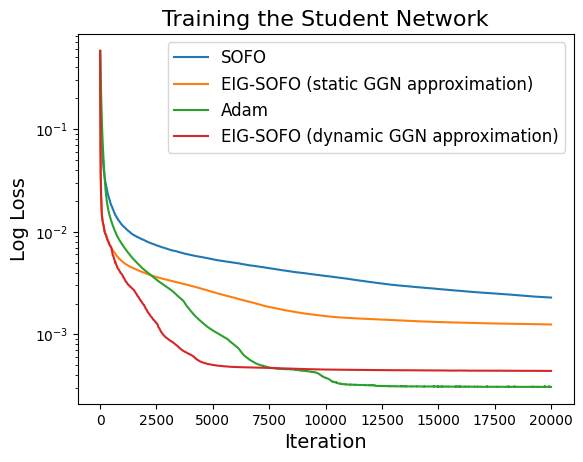

In [47]:
import pickle

plt.plot(sofo_losses, label='SOFO')
plt.plot(sofo_eigs_losses, label='EIG-SOFO (static GGN approximation)')
plt.plot(adam_losses, label='Adam')
plt.plot(sofo_eigs_losses_keep_learning, label='EIG-SOFO (dynamic GGN approximation)')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.title('Training the Student Network', fontsize=16)
plt.yscale('log')
plt.legend(fontsize=12)
plt.show()

with open(f'sofo_losses10.pkl', 'wb') as f:
    pickle.dump(sofo_losses, f)

with open(f'small_sofo_eigs_losses10.pkl', 'wb') as f:
    pickle.dump(sofo_eigs_losses, f)

with open(f'small_sofo_eigs_losses_keep_learning10.pkl', 'wb') as f:
    pickle.dump(sofo_eigs_losses_keep_learning, f)

with open(f'small_adam_losses10.pkl', 'wb') as f:
    pickle.dump(adam_losses, f)



In [56]:
with open('sofo_losses7.pkl', 'rb') as f:
    sofo_losses_loaded = pickle.load(f)

with open('sofo_eigs_losses7.pkl', 'rb') as f:
    sofo_losses_loaded2 = pickle.load(f)

with open('sofo_eigs_losses_keep_learning7.pkl', 'rb') as f:
    sofo_losses_loaded3 = pickle.load(f)

with open('adam_losses7.pkl', 'rb') as f:
    sofo_losses_loaded4 = pickle.load(f)

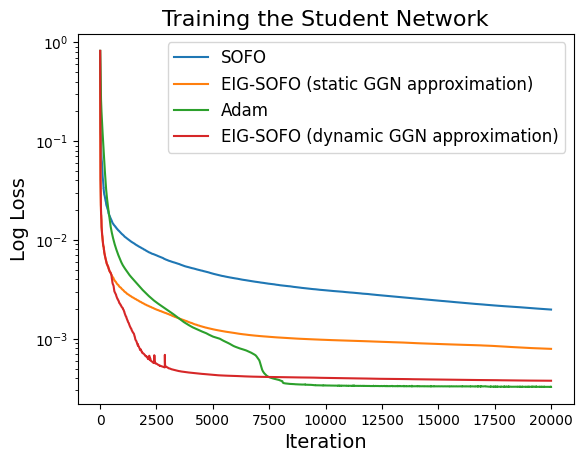

In [57]:
plt.plot(sofo_losses_loaded, label='SOFO')
plt.plot(sofo_losses_loaded2, label='EIG-SOFO (static GGN approximation)')
plt.plot(sofo_losses_loaded4, label='Adam')
plt.plot(sofo_losses_loaded3, label='EIG-SOFO (dynamic GGN approximation)')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.title('Training the Student Network', fontsize=16)
plt.yscale('log')
plt.legend(fontsize=12)
plt.show()

In [42]:
import pickle
indices = [0, 1, 4, 5, 6, 7, 8, 9]

no_of_iters = 20000

sofo_total = np.zeros((len(indices), no_of_iters))
sofo_eigs_total = np.zeros((len(indices), no_of_iters))
sofo_eigs_keep_learning_total = np.zeros((len(indices), no_of_iters))
adam_total = np.zeros((len(indices), no_of_iters))

c = 0
for i in indices:
    with open(f'sofo_losses{i}.pkl', 'rb') as f:
        sofo_losses_loaded = pickle.load(f)
        sofo_total[c, :] = sofo_losses_loaded
    with open(f'sofo_eigs_losses{i}.pkl', 'rb') as f:
        sofo_losses_loaded2 = pickle.load(f)
        sofo_eigs_total[c, :] = sofo_losses_loaded2
    with open(f'sofo_eigs_losses_keep_learning{i}.pkl', 'rb') as f:
        sofo_losses_loaded3 = pickle.load(f)
        sofo_eigs_keep_learning_total[c, :] = sofo_losses_loaded3
    with open(f'adam_losses{i}.pkl', 'rb') as f:
        sofo_losses_loaded4 = pickle.load(f)
        adam_total[c, :] = sofo_losses_loaded4
    c += 1

std_dev_sofo = np.std(sofo_total, axis=0)
std_dev_sofo_eigs = np.std(sofo_eigs_total, axis=0)
std_dev_sofo_eigs_keep_learning = np.std(sofo_eigs_keep_learning_total, axis=0)
std_dev_adam = np.std(adam_total, axis=0)

mean_sofo = np.mean(sofo_total, axis=0)
mean_sofo_eigs = np.mean(sofo_eigs_total, axis=0)
mean_sofo_eigs_keep_learning = np.mean(sofo_eigs_keep_learning_total, axis=0)

mean_adam = np.mean(adam_total, axis=0)

median_sofo = np.median(sofo_total, axis=0)
median_sofo_eigs = np.median(sofo_eigs_total, axis=0)
median_sofo_eigs_keep_learning = np.median(sofo_eigs_keep_learning_total, axis=0)
median_adam = np.median(adam_total, axis=0)

percentile25_sofo = np.percentile(sofo_total, 25, axis=0)
percentile75_sofo = np.percentile(sofo_total, 75, axis=0)
percentile25_sofo_eigs = np.percentile(sofo_eigs_total, 25, axis=0)
percentile75_sofo_eigs = np.percentile(sofo_eigs_total, 75, axis=0)
percentile25_sofo_eigs_keep_learning = np.percentile(sofo_eigs_keep_learning_total, 25, axis=0)
percentile75_sofo_eigs_keep_learning = np.percentile(sofo_eigs_keep_learning_total, 75, axis=0)
percentile25_adam = np.percentile(adam_total, 25, axis=0)
percentile75_adam = np.percentile(adam_total, 75, axis=0)

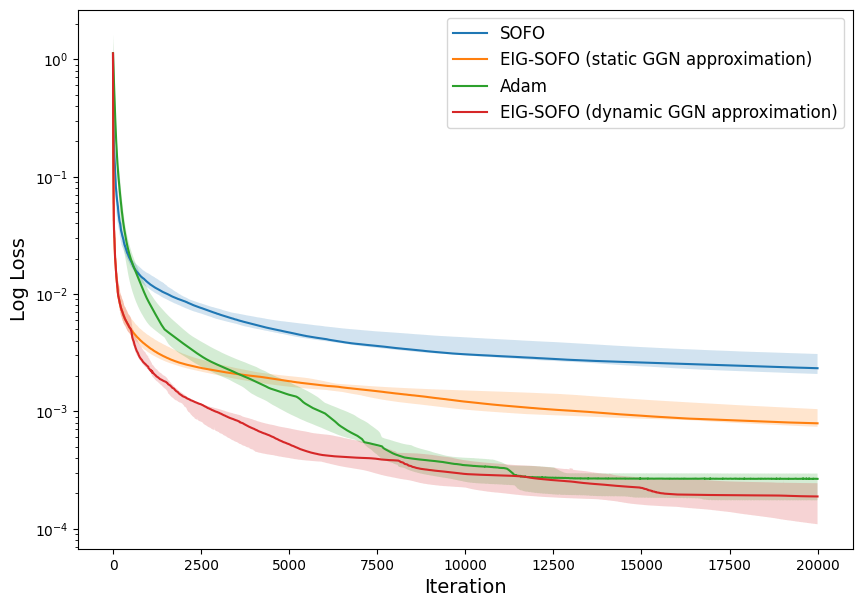

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(median_sofo, label='SOFO')
plt.fill_between(np.arange(no_of_iters), percentile25_sofo, percentile75_sofo, alpha=0.2)

plt.plot(median_sofo_eigs, label='EIG-SOFO (static GGN approximation)')
plt.fill_between(np.arange(no_of_iters), percentile25_sofo_eigs, percentile75_sofo_eigs, alpha=0.2)

plt.plot(median_adam, label='Adam')
plt.fill_between(np.arange(no_of_iters), percentile25_adam, percentile75_adam, alpha=0.2)

plt.plot(median_sofo_eigs_keep_learning, label='EIG-SOFO (dynamic GGN approximation)')
plt.fill_between(np.arange(no_of_iters), percentile25_sofo_eigs_keep_learning, percentile75_sofo_eigs_keep_learning, alpha=0.2)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=12)
plt.savefig('final_results(Nh=25).png', dpi=300)
plt.show()

In [64]:
indices = [0, 1, 2, 3, 4, 5, 6, 7]

no_of_iters = 20000

sofo_total = np.zeros((len(indices), no_of_iters))
sofo_eigs_total = np.zeros((len(indices), no_of_iters))
sofo_eigs_keep_learning_total = np.zeros((len(indices), no_of_iters))
adam_total = np.zeros((len(indices), no_of_iters))

c = 0
for i in indices:
    with open(f'small_sofo_losses{i}.pkl', 'rb') as f:
        sofo_losses_loaded = pickle.load(f)
        sofo_total[c, :] = sofo_losses_loaded
    with open(f'small_sofo_eigs_losses{i}.pkl', 'rb') as f:
        sofo_losses_loaded2 = pickle.load(f)
        sofo_eigs_total[c, :] = sofo_losses_loaded2
    with open(f'small_sofo_eigs_losses_keep_learning{i}.pkl', 'rb') as f:
        sofo_losses_loaded3 = pickle.load(f)
        sofo_eigs_keep_learning_total[c, :] = sofo_losses_loaded3
    with open(f'small_adam_losses{i}.pkl', 'rb') as f:
        sofo_losses_loaded4 = pickle.load(f)
        adam_total[c, :] = sofo_losses_loaded4
    c += 1


In [68]:
median_sofo = np.median(sofo_total, axis=0)
median_sofo_eigs = np.median(sofo_eigs_total, axis=0)
median_sofo_eigs_keep_learning = np.median(sofo_eigs_keep_learning_total, axis=0)
median_adam = np.median(adam_total, axis=0)
percentile25_sofo = np.percentile(sofo_total, 25, axis=0)
percentile75_sofo = np.percentile(sofo_total, 75, axis=0)
percentile25_sofo_eigs = np.percentile(sofo_eigs_total, 25, axis=0)
percentile75_sofo_eigs = np.percentile(sofo_eigs_total, 75, axis=0)
percentile25_sofo_eigs_keep_learning = np.percentile(sofo_eigs_keep_learning_total, 25, axis=0)
percentile75_sofo_eigs_keep_learning = np.percentile(sofo_eigs_keep_learning_total, 75, axis=0)
percentile25_adam = np.percentile(adam_total, 25, axis=0)
percentile75_adam = np.percentile(adam_total, 75, axis=0)

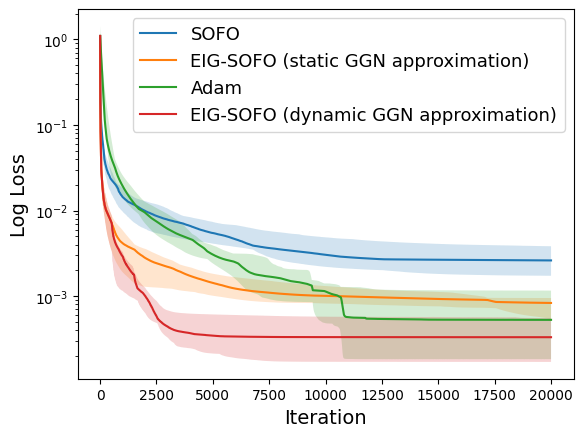

In [70]:
plt.plot(median_sofo, label='SOFO')
plt.fill_between(np.arange(no_of_iters), percentile25_sofo, percentile75_sofo, alpha=0.2)

plt.plot(median_sofo_eigs, label='EIG-SOFO (static GGN approximation)')
plt.fill_between(np.arange(no_of_iters), percentile25_sofo_eigs, percentile75_sofo_eigs, alpha=0.2)

plt.plot(median_adam, label='Adam')
plt.fill_between(np.arange(no_of_iters), percentile25_adam, percentile75_adam, alpha=0.2)

plt.plot(median_sofo_eigs_keep_learning, label='EIG-SOFO (dynamic GGN approximation)')
plt.fill_between(np.arange(no_of_iters), percentile25_sofo_eigs_keep_learning, percentile75_sofo_eigs_keep_learning, alpha=0.2)

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=13)
plt.savefig('final_results(Nh=10)_extra.png', dpi=300)
plt.show()